In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import numpy as np
from numpy.random import choice, normal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
sns.set_style('white')
np.random.seed(seed=42)
results_path = Path('results', 'random_forest')
if not results_path.exists():
    results_path.mkdir(parents=True)

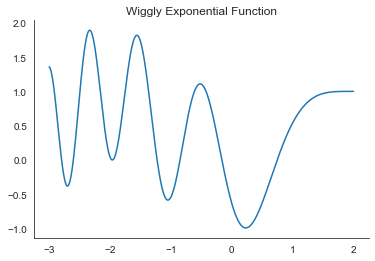

In [6]:
def f(x):
    return np.exp(-(x+2) ** 2) + np.cos((x-2)**2)

x = np.linspace(-3, 2, 1000)
y = pd.Series(f(x), index=x)
y.plot(title='Wiggly Exponential Function')
sns.despine()

In [8]:
test_size = 500
train_size = 250
reps = 100

noise = .5  # noise relative to std(y)
noise = y.std() * noise

# random sampling by choice function
X_test = choice(x, size=test_size, replace=False)

max_depth = 10
n_estimators=10

tree = DecisionTreeRegressor(max_depth=max_depth)
bagged_tree = BaggingRegressor(base_estimator=tree, n_estimators=n_estimators)
learners = {'Decision Tree': tree, 'Bagging Regressor': bagged_tree}

predictions = {k: pd.DataFrame() for k, v in learners.items()}
predictions

{'Decision Tree': Empty DataFrame
 Columns: []
 Index: [],
 'Bagging Regressor': Empty DataFrame
 Columns: []
 Index: []}

In [16]:
for i in range(reps):
    X_train = choice(x, train_size)
    y_train = f(X_train) + normal(scale=noise, size=train_size)
    for label, learner in learners.items():
        learner.fit(X=X_train.reshape(-1, 1), y=y_train)
        preds = pd.DataFrame({i: learner.predict(X_test.reshape(-1, 1))}, index=X_test)
        predictions[label] = pd.concat([predictions[label], preds], axis=1)

# y only observed with noise
y_true = pd.Series(f(X_test), index=X_test)
y_test = pd.DataFrame(y_true.values.reshape(-1,1) + normal(scale=noise, size=(test_size, reps)), index=X_test)

result = pd.DataFrame()
for label, preds in predictions.items():
    result[(label, 'error')] = preds.sub(y_test, axis=0).pow(2).mean(1)    # mean squared error
    result[(label, 'bias')] = y_true.sub(preds.mean(axis=1), axis=0).pow(2)             # bias
    result[(label, 'variance')] = preds.var(axis=1)
    result[(label, 'noise', )] = y_test.var(axis=1)
result.columns = pd.MultiIndex.from_tuples(result.columns)
df = result.mean().sort_index().loc['Decision Tree']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'-0.21%'

In [17]:
df = result.mean().sort_index().loc['Bagging Regressor']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'0.02%'

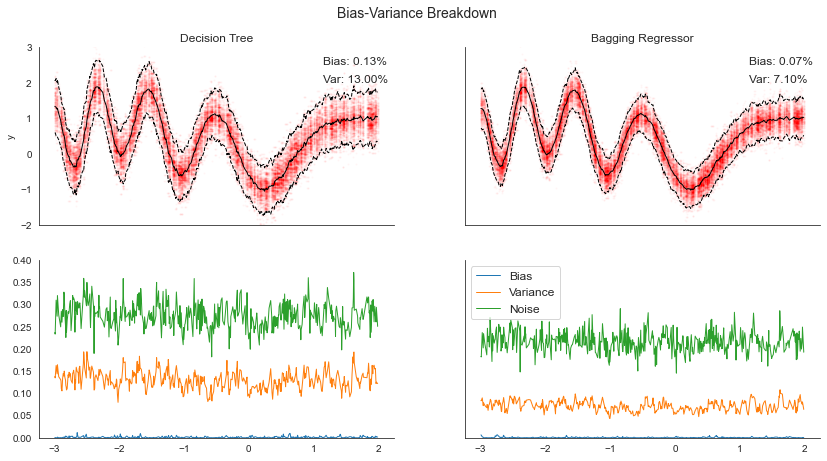

In [31]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14, 7), sharex=True, sharey='row')
axes = axes.flatten()
idx = pd.IndexSlice

for i, (model, data) in enumerate(predictions.items()):
    mean, std = data.mean(1), data.std(1).mul(2)
    (pd.DataFrame([mean.sub(std), mean, mean.add(std)]).T.sort_index()
     .plot(style=['k--', 'k-', 'k--'], ax=axes[i], lw=1, legend=False, ylim=(-2, 3)))
    (data.stack().reset_index().rename(columns={'level_0': 'x', 0: 'y'})
     .plot.scatter(x='x', y='y', ax=axes[i], alpha=.02, s=2, color='r', title=model))
    r = result[model]
    m = r.mean()
    kwargs = {'transform': axes[i].transAxes, 'fontsize':12}
    axes[i].text(x=.8, y=.9, s=f'Bias: {m.bias:.2%}', **kwargs)
    axes[i].text(x=.8, y=.8, s=f'Var: {m.variance:.2%}', **kwargs)

    (r.drop('error', axis=1).sort_index().rename(columns=str.capitalize)
     .plot(ax=axes[i+2], lw=1, legend=False, stacked=True, ylim=(0, .4)))

axes[-1].legend(fontsize=12)
fig.suptitle('Bias-Variance Breakdown', fontsize=14)
sns.despine()
fig.subplots_adjust(top=.9);